# Activations
## Introduction
As was shown in [this paper](https://arxiv.org/abs/2004.06093), neural networks operate with the topology of data, simplifying it in terms on Betti numbers. The effect of topological simplification mostly occurs in the last layers of deep neural network. This in fact can explain the superiority of deep NNs compared to shallow ones. Moreover, the superiority of `ReLU` activation function is explained via its topological properties: it isn't a homeomorphism and is really simplifying the underlying topology of the data.

In this notebook we try to operate with topology in the first layers, efficiently destroying the "high-dimensional" topological features in order to simplify the neural networks architecture. But instead of shrinking the data as `ReLU` does, we split the data. Such activation function also gives an example of non-homeomorphism, which can simplify the topology in the proper way.

## Imports

In [1]:
%%capture
%cd ..
!pip install -r requirements.txt

In [2]:
from src.experiments import ActivationExperiments
from src.models import *
from src.datasets import Circles, Tori
import matplotlib.pyplot as plt
import torch

## Split activation

According to [the paper](https://arxiv.org/abs/2004.06093), the reason of `ReLU` superiority is the fact, that `ReLU` is not a homeomorphism, compared to `tanh` or `sigmoid` functions. In particular, `ReLU` changes the topology by squashing the data.

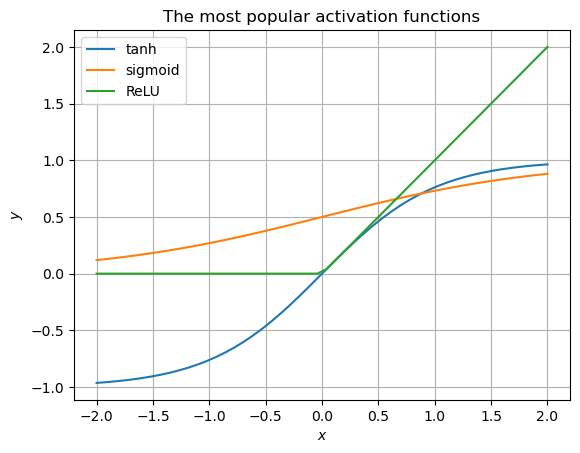

In [3]:
x = torch.linspace(-2.,2.,50)
plt.plot(x, torch.tanh(x), label='tanh')
plt.plot(x, torch.sigmoid(x), label='sigmoid')
plt.plot(x, torch.relu(x), label='ReLU')
plt.grid(True, which='both')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('The most popular activation functions')
plt.show()

Thus, the superiority of `ReLU` can be explained via its influence on the topology of the data, `ReLU` can 'squash' the data. In the mentioned paper `ReLU` simplifies the topology way better than `tanh`, which is, indeed, pretty obvious from the mathematical POV.

But is there any function which also can provide the changes in topology? 

Notice that `ReLU` is not a homeomorphism since it isn't bijective: injectivity fails. But one can consider non-surjective function as well, e.g. a function with jump discontinuity. The simplest one is the following $$ f:\mathbb{R}\to\mathbb{R}: x \mapsto \begin{cases} x + c, \text{ if } c\geq 0\\ x - c. \text{ if } c \leq 0  \end{cases} $$
Or, written shortly, $$ f: x\mapsto x + \operatorname{sign}{x} \cdot c $$

In order to make a split anywhere, one can modify the function in the following way: $$ f: x\mapsto x + \operatorname{sign}{(x - a)} \cdot c $$

But if the parameter $a$ is learnable (this is the case we really want), it won't really be updated since $$ \frac{\partial f}{\partial a} = -2\delta(x-a) $$

So, one can smoothify it. E.g. using the following: $$ g: x\mapsto x + \operatorname{tanh}{\lambda(x - a)} \cdot c $$

With large $\lambda$ values, $g$ approximates $f$ very nice

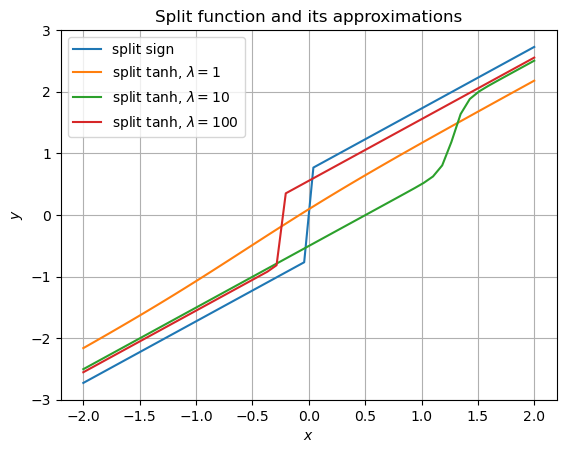

In [4]:
x = torch.linspace(-2.,2.,50)
plt.plot(x, split_sign()(x).detach().numpy(), label='split sign')
plt.plot(x, split_tanh(lamb=1.)(x).detach().numpy(), label='split tanh, $\lambda=1$')
plt.plot(x, split_tanh(lamb=10.)(x).detach().numpy(), label='split tanh, $\lambda=10$')
plt.plot(x, split_tanh(lamb=100.)(x).detach().numpy(), label='split tanh, $\lambda=100$')
plt.grid(True, which='both')
plt.legend(loc='best')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Split function and its approximations')
plt.show()

Summing up, in order to create such a topology-destroying function, the activation function should _not_ be a homeomorphism. In particular, it should not be a bijective function. That is, it's either non-injective or non-surjective. `ReLU` is not injective and any other non-injective function will in fact do the same what `ReLU` does: it will squash the data. 

On the other hand, there were no non-surjective functions. And really there were no need in such activation functions before. But when it comes to destroying the topology, such activation function can really be crucial. And that `split function` is an example of non-surjective activation function.

## Experiments

Let's perform the experiments for this activation function. 

Will do the following: let's train a neural network in which 
 1. first activation function is going to be a split activation
 2. all activation functions are going to be the split activation functions

In [5]:
experiments1 = ActivationExperiments(Classifier1L, datasets=[Circles(), Tori()], n_experiments=2, num_of_hidden_layers=range(1, 2),
        dim_of_hidden_layers=range(3, 7),
        list_of_activations=[
            "split_tanh",
            "split_sincos",
            "relu",
        ],verbose=False)

In [ ]:
%%time
experiments1.run_experiments()

Experimenting with dataset circles
№ of layers = 1;	 dim of hidden = 3;	 activation is split_tanh


 experiments:  50%|███████████████▌               | 1/2 [00:28<00:28, 28.23s/it]